In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

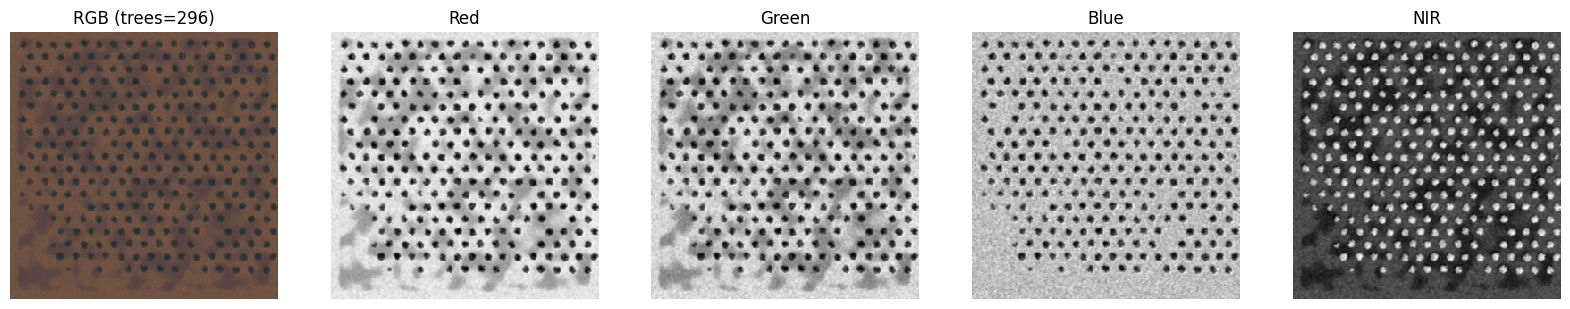

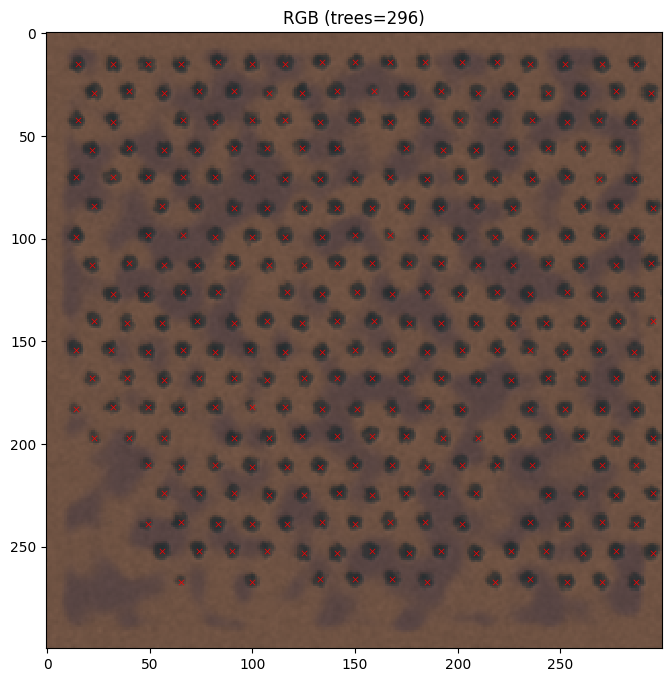

In [65]:

index = 0

# dir = "generated_dataset2/test"
# batch = "00504"
# output = np.load(os.path.join(dir, f"batch{batch}.npy"))
# coordinates = np.load(os.path.join(dir, f"coordinatesbatch{batch}.npz"))
# count = np.load(os.path.join(dir, f"countbatch{batch}.npy"))
# normalize_value = 1

dir = "outputs"
output = np.load(os.path.join(dir, f"output.npy"))
coordinates = np.load(os.path.join(dir, f"coordinates.npz"))
count = np.load(os.path.join(dir, f"count.npy"))
normalize_value = 1600

image = (output[index]).transpose(1, 2, 0)/normalize_value

fig, axs = plt.subplots(1, 5, figsize=(20, 15))
axs[0].imshow(image[:,:,:3])
axs[1].imshow(image[:,:,0], cmap="gray")
axs[2].imshow(image[:,:,1], cmap="gray")
axs[3].imshow(image[:,:,2], cmap="gray")
axs[4].imshow(image[:,:,3], cmap="gray")

axs[0].set_title(f"RGB (trees={count[index].item()})")
axs[1].set_title("Red")
axs[2].set_title("Green")
axs[3].set_title("Blue")
axs[4].set_title("NIR")

for i in range(5):
    axs[i].axis("off")

fig.show()

coords = coordinates[f"coords{index}"]

figsize = 8
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize))
ax.imshow(image[:,:,:3])
ax.scatter(coords[:, 0], coords[:, 1], marker='x', c="red", linewidths=0.5, s=15, alpha=1.0)
circles = [Circle((xi, yi), radius=ri/2) for xi, yi, ri in coords]
collection = PatchCollection(circles, facecolor='none', edgecolor='red', linewidth=0.3)
# ax.add_collection(collection)

ax.set_title(f"RGB (trees={count[index].item()})")

fig.show()

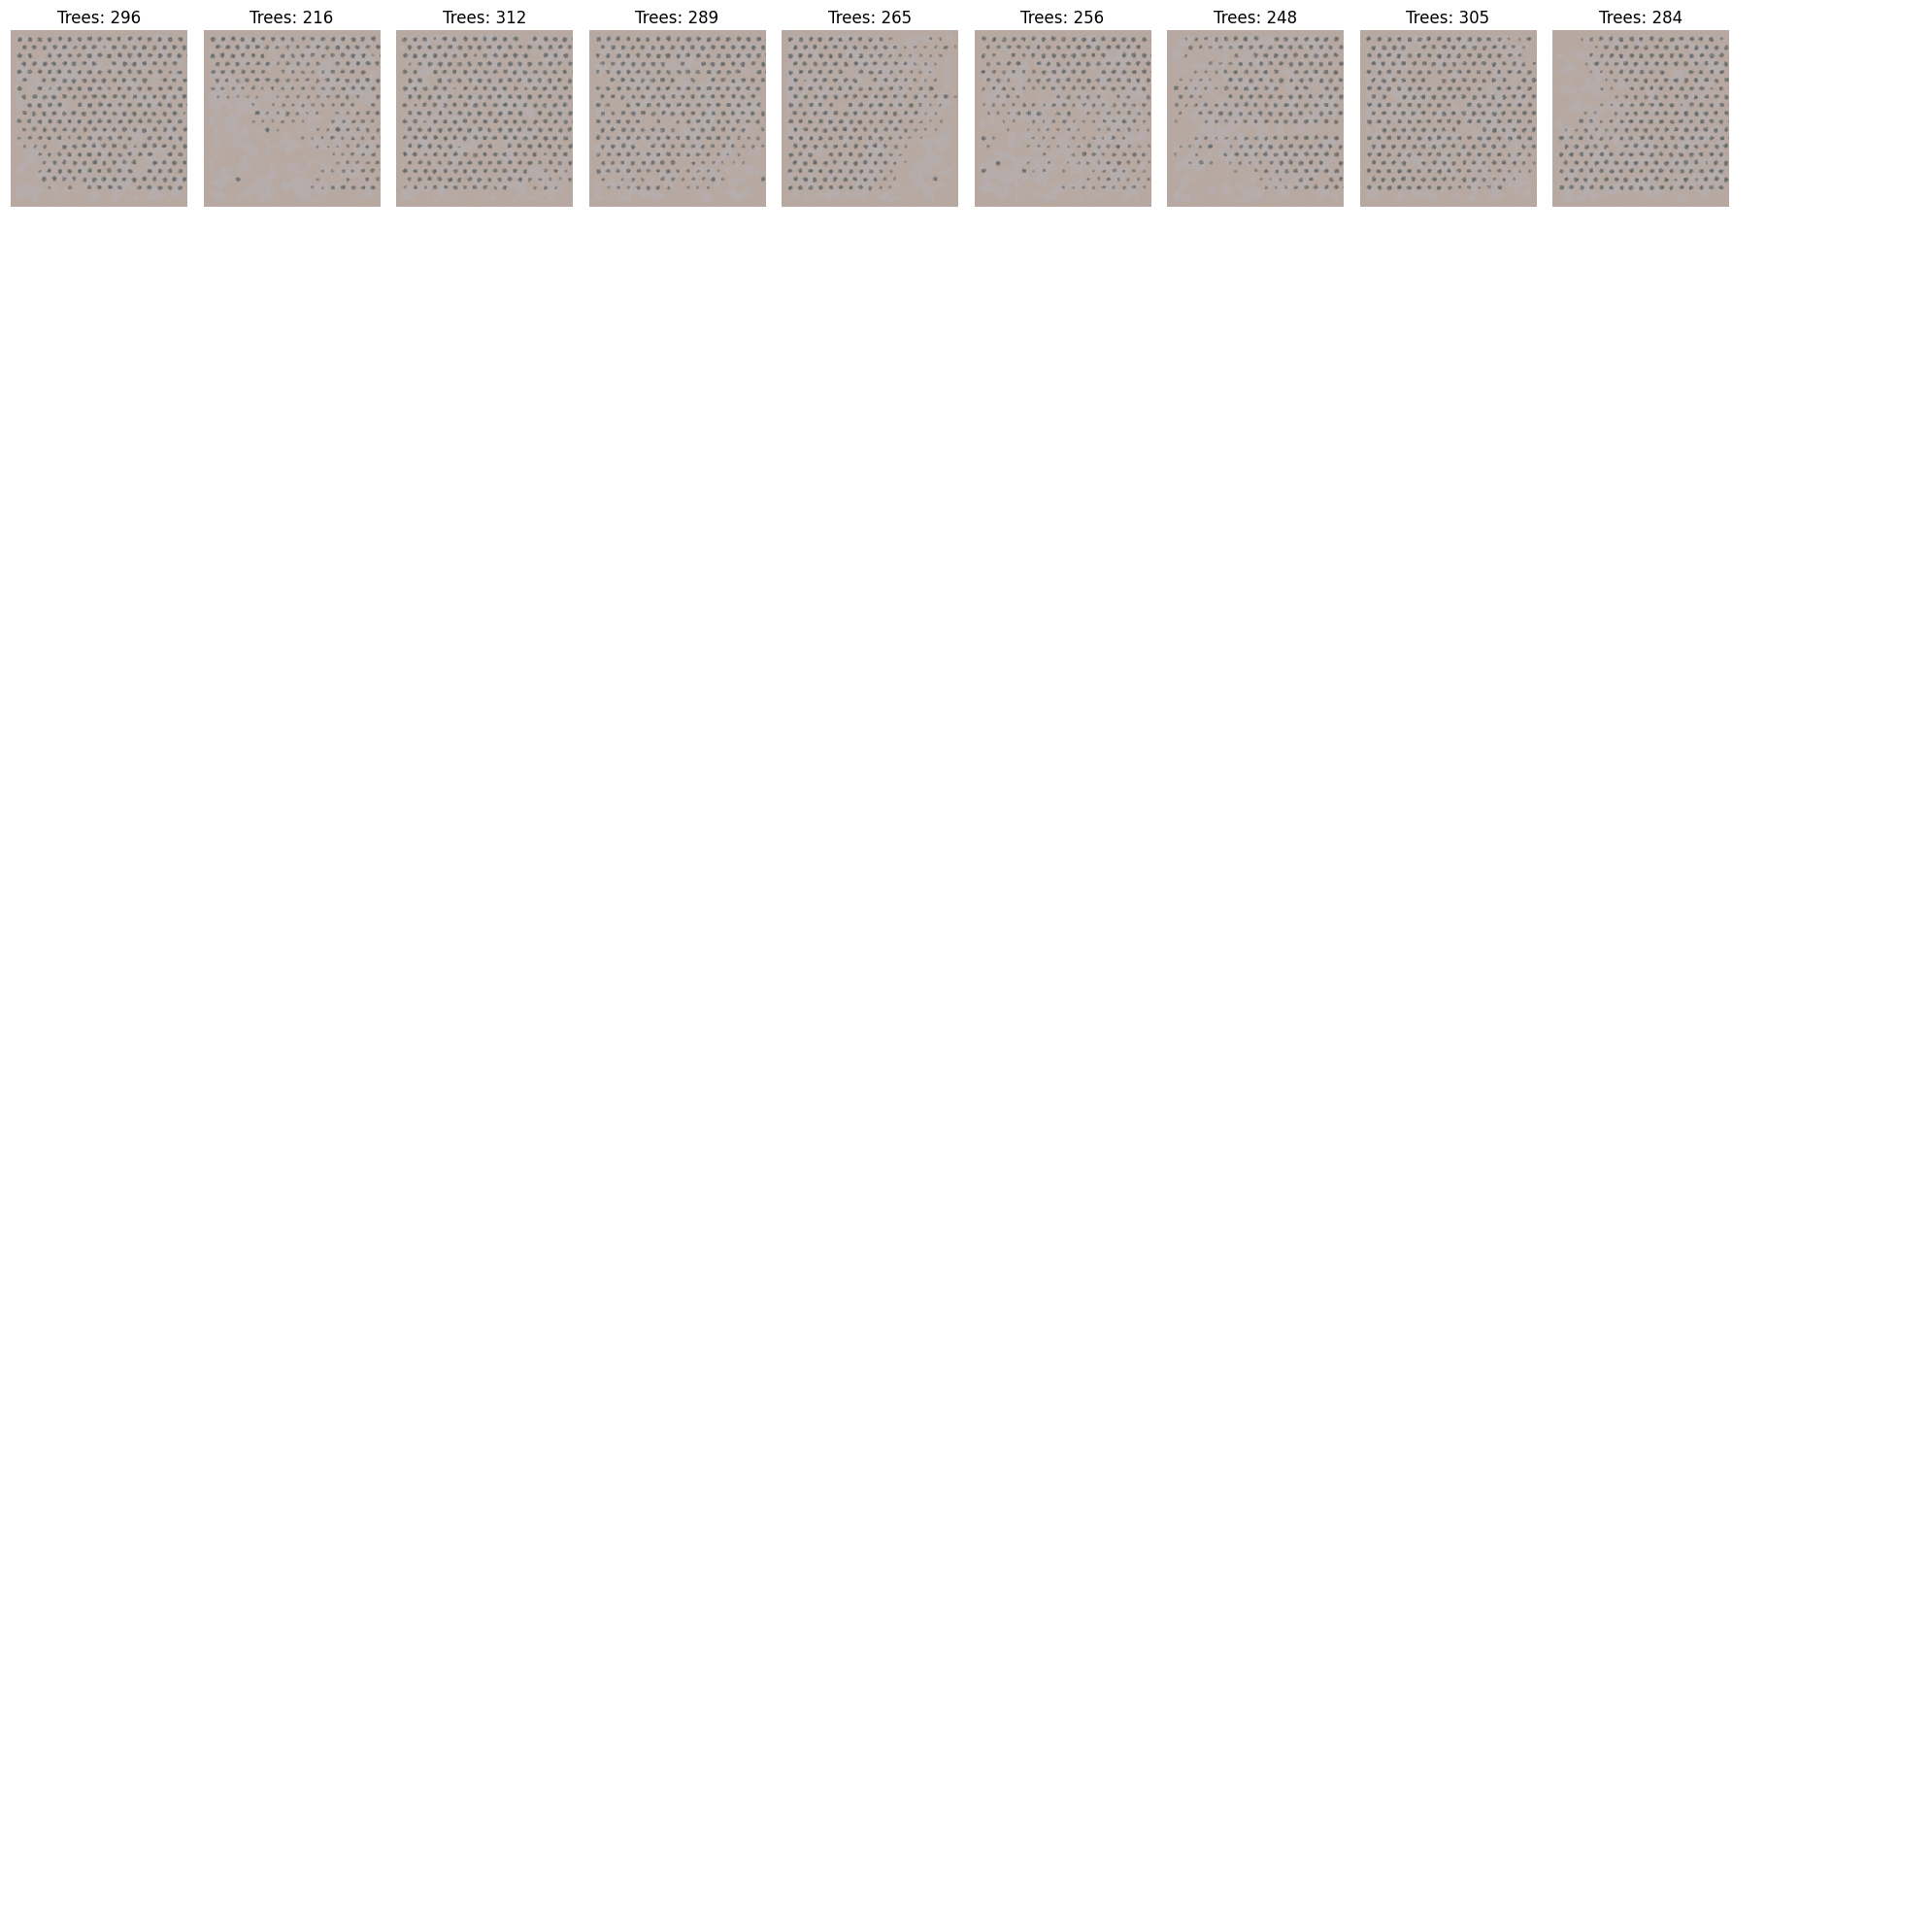

In [66]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        if idx < len(output):
            axs[i, j].imshow((output[idx]).transpose(1, 2, 0)/normalize_value)
            axs[i, j].set_title(f"Trees: {count[idx].item()}")
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()